# Neurod2 target analysis

Notebooks analyses Neurod2 targets, identifying the Neurod2 - Rfx6 regulatory link for epsilon cells.

## Library imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.perturbation import (
    aggregate_model_predictions,
    get_list_name,
    inferred_GRN,
    RegulationScanning,
)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "pancreatic_endocrine"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)
    (DATA_DIR / DATASET / "results" / "Neurod2_screening_repeat_runs").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [6]:
TERMINAL_STATES = ["Alpha", "Beta", "Delta", "Epsilon"]

## Data loading

In [7]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed_filtered.h5ad")

In [8]:
palette = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))

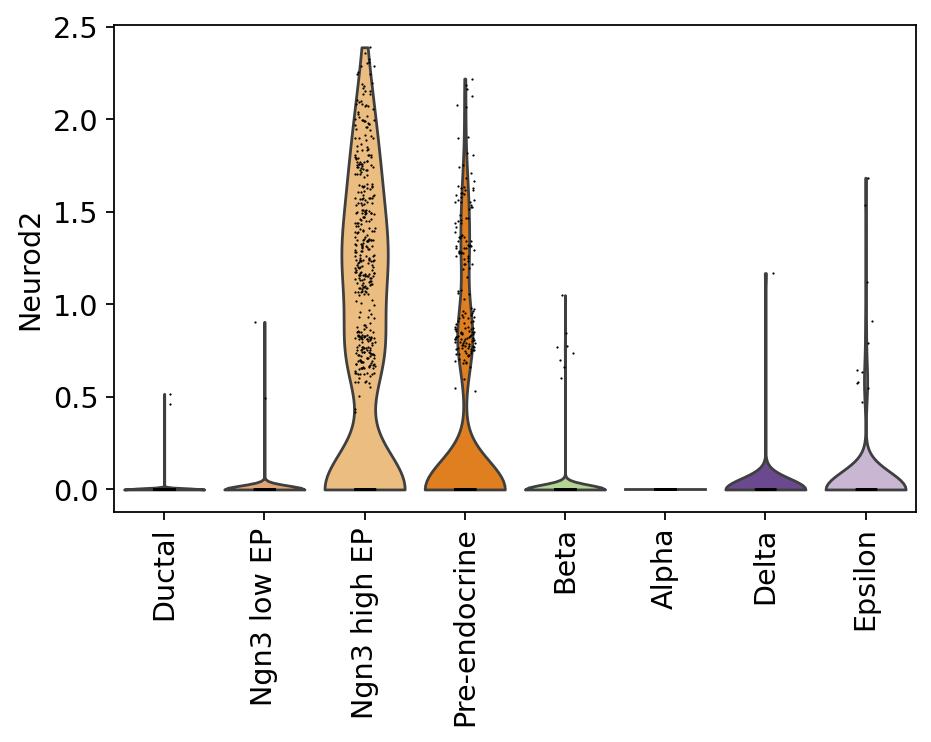

In [9]:
sc.pl.violin(adata, keys="Neurod2", groupby="clusters", rotation=90)

## Build RegVelo's GRN

In [10]:
GRN_list = []  # Assuming there are 4 metrics

for i in range(5):
    model_name = "rgv_model_" + str(i)
    model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / model_name
    ### load model
    vae = REGVELOVI.load(model, adata)
    GRN_list.append(inferred_GRN(vae, adata, label="clusters", group="all"))

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       
Computing global GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       
Computing global GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.p

In [11]:
grn_all = np.mean(np.stack(GRN_list), axis=0)

In [12]:
predict_weight = grn_all[:, [i == "Neurod2" for i in adata.var.index]]
prior = vae.module.v_encoder.mask_m_raw[:, [i == "Neurod2" for i in adata.var.index]].detach().cpu().numpy()

In [13]:
predict_weight = pd.DataFrame(predict_weight, index=adata.var.index)
predict_weight.loc[:, "weight"] = predict_weight.iloc[:, 0].abs()
predict_weight.loc[:, "prior"] = prior

## Screening from top-10 targets

In [14]:
genes = predict_weight.sort_values("weight", ascending=False).iloc[:10, :].index.tolist()

In [16]:
terminal_states = ["Alpha", "Delta", "Beta", "Epsilon"]
for i in range(5):
    print("loading model...")
    model_name = "rgv_model_" + str(i)
    model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / model_name

    coef_name = "coef_" + str(i)
    res_save_coef = DATA_DIR / DATASET / "results" / "Neurod2_screening_repeat_runs" / coef_name

    pval_name = "pval_" + str(i)
    res_save_pval = DATA_DIR / DATASET / "results" / "Neurod2_screening_repeat_runs" / pval_name

    print("inferring perturbation...")
    perturb_screening = RegulationScanning(
        model, adata, 8, "clusters", TERMINAL_STATES, "Neurod2", genes, 0, method="t-statistics"
    )
    coef = pd.DataFrame(np.array(perturb_screening["coefficient"]))
    coef.index = perturb_screening["target"]
    coef.columns = get_list_name(perturb_screening["coefficient"][0])
    pval = pd.DataFrame(np.array(perturb_screening["pvalue"]))
    pval.index = perturb_screening["target"]
    pval.columns = get_list_name(perturb_screening["pvalue"][0])

    coef.to_csv(res_save_coef)
    pval.to_csv(res_save_pval)

loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:02:15,686 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:03:20,561 - INFO - Using pre-computed Schur decomposition


Done Rfx3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:04:25,869 - INFO - Using pre-computed Schur decomposition


Done Adk
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:05:35,107 - INFO - Using pre-computed Schur decomposition


Done Zfp148
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:06:40,912 - INFO - Using pre-computed Schur decomposition


Done Nfatc2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
2024-12-02 03:07:48,922 - INFO - Using pre-computed Schur decomposition


Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:08:53,042 - INFO - Using pre-computed Schur decomposition


Done Setbp1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:09:57,210 - INFO - Using pre-computed Schur decomposition


Done Cdh1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:11:01,191 - INFO - Using pre-computed Schur decomposition


Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:12:04,553 - INFO - Using pre-computed Schur decomposition


Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 2024-12-02 03:13:08,114 - INFO - Using pre-computed Schur decomposition


Done Grb10
loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:14:11,869 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:15:15,199 - INFO - Using pre-computed Schur decomposition


Done Rfx3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:16:18,177 - INFO - Using pre-computed Schur decomposition


Done Adk
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:17:23,089 - INFO - Using pre-computed Schur decomposition


Done Zfp148
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:18:26,791 - INFO - Using pre-computed Schur decomposition


Done Nfatc2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:19:29,193 - INFO - Using pre-computed Schur decomposition


Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:20:32,723 - INFO - Using pre-computed Schur decomposition


Done Setbp1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:21:37,398 - INFO - Using pre-computed Schur decomposition


Done Cdh1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:22:41,618 - INFO - Using pre-computed Schur decomposition


Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
2024-12-02 03:23:45,328 - INFO - Using pre-computed Schur decomposition


Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:24:48,136 - INFO - Using pre-computed Schur decomposition


Done Grb10
loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:25:54,344 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:26:59,182 - INFO - Using pre-computed Schur decomposition


Done Rfx3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:28:03,561 - INFO - Using pre-computed Schur decomposition


Done Adk
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:29:07,961 - INFO - Using pre-computed Schur decomposition


Done Zfp148
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:30:11,971 - INFO - Using pre-computed Schur decomposition


Done Nfatc2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:31:15,482 - INFO - Using pre-computed Schur decomposition


Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:32:19,845 - INFO - Using pre-computed Schur decomposition


Done Setbp1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:33:24,269 - INFO - Using pre-computed Schur decomposition


Done Cdh1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:34:28,064 - INFO - Using pre-computed Schur decomposition


Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:35:31,585 - INFO - Using pre-computed Schur decomposition


Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:36:35,499 - INFO - Using pre-computed Schur decomposition


Done Grb10
loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:37:38,550 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:38:41,487 - INFO - Using pre-computed Schur decomposition


Done Rfx3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:39:46,840 - INFO - Using pre-computed Schur decomposition


Done Adk
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:40:49,455 - INFO - Using pre-computed Schur decomposition


Done Zfp148
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:41:54,077 - INFO - Using pre-computed Schur decomposition


Done Nfatc2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:42:57,801 - INFO - Using pre-computed Schur decomposition


Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:44:02,697 - INFO - Using pre-computed Schur decomposition


Done Setbp1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:45:06,043 - INFO - Using pre-computed Schur decomposition


Done Cdh1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:46:10,795 - INFO - Using pre-computed Schur decomposition


Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:47:15,665 - INFO - Using pre-computed Schur decomposition


Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:48:19,237 - INFO - Using pre-computed Schur decomposition


Done Grb10
loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
2024-12-02 03:49:24,092 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:50:28,964 - INFO - Using pre-computed Schur decomposition


Done Rfx3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:51:32,437 - INFO - Using pre-computed Schur decomposition


Done Adk
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:52:35,489 - INFO - Using pre-computed Schur decomposition


Done Zfp148
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:53:39,498 - INFO - Using pre-computed Schur decomposition


Done Nfatc2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:54:43,203 - INFO - Using pre-computed Schur decomposition


Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:55:47,949 - INFO - Using pre-computed Schur decomposition


Done Setbp1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:56:52,225 - INFO - Using pre-computed Schur decomposition


Done Cdh1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 03:57:56,033 - INFO - Using pre-computed Schur decomposition


Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 2024-12-02 03:58:58,973 - INFO - Using pre-computed Schur decomposition


Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

2024-12-02 04:00:03,972 - INFO - Using pre-computed Schur decomposition


Done Grb10


## Plot perturbation results

In [17]:
Neurod2_target_perturbation = aggregate_model_predictions(
    DATA_DIR / DATASET / "results" / "Neurod2_screening_repeat_runs", method="t-statistics"
)

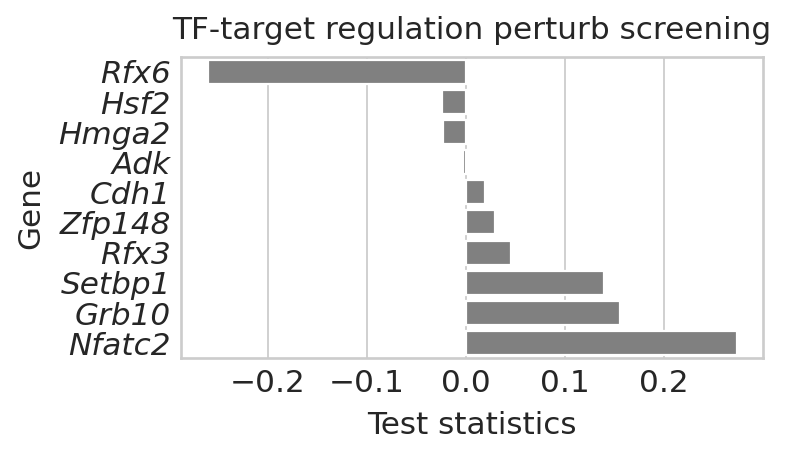

In [18]:
## rank the Epsilon prediction results
with mplscience.style_context():  # Entering the custom style context
    sns.set_style("whitegrid")
    gene_scores = pd.DataFrame(
        {
            "Gene": Neurod2_target_perturbation[0].index.tolist(),
            "Score": Neurod2_target_perturbation[0].loc[:, "Epsilon"],
        }
    )
    gene_scores.loc[:, "weights"] = gene_scores.loc[:, "Score"].abs()
    # gene_scores = gene_scores.sort_values(by='weights', ascending=False).iloc[:10,:]
    gene_scores = gene_scores.sort_values(by="Score", ascending=True).iloc[:10, :]
    # Create the horizontal bar plot using Seaborn
    fig, ax = plt.subplots(figsize=(5, 3))
    g = sns.barplot(x="Score", y="Gene", data=gene_scores, color="grey")

    # Customize plot aesthetics
    g.set_ylabel("Gene", fontsize=14)
    g.set_xlabel("Test statistics", fontsize=14)

    # Customize tick parameters for better readability
    g.tick_params(axis="x", labelsize=14)
    g.tick_params(axis="y", labelsize=14)
    g.set_title("TF-target regulation perturb screening", fontsize=14)

    plt.tight_layout()
    plt.setp(g.get_yticklabels(), fontstyle="italic")

    if SAVE_FIGURES:
        save_path = FIG_DIR / DATASET / "Neurod2_target_screening.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")
    plt.show()